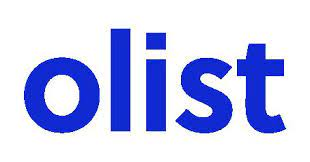

# Importation des bibliothèques et des données

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from math import radians
from sklearn.metrics.pairwise import haversine_distances
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')
import os
pd.set_option('display.max_columns', None)

# Fréquence de mise à jour

Ici le but est de déterminer la fréquence de mise à jour. Pour ça, on va utiliser ici le ari score qui va être basé dans une première version sur une période de 2 semaines et une deuxième version qui sera basée sur le nombre de clients.

**ARI score**:

ARI qui est la normalisation de l'indice de rand va permettre de comparer deux partitions de nombres de classes différentes qui va renvoyer un score compris entre O et 1 où :
- 0 les clusters sont définis aléatoirement
- 1 les clusters sont identiques

Pour la suite on va créer deux fonctions qui vont reprendre une partie du  nettoyage effectué avant et garder les variables RFM afin de faire la simulation.

In [ ]:
def features(df):
    df = df.query('order_status == "delivered"').drop('order_status', axis = 1)

    recency = (df.order_purchase_timestamp.max() - df.groupby('customer_unique_id').order_purchase_timestamp.max()).dt.days.to_frame('Recency').reset_index()

    frequency = frequency = df.groupby('customer_unique_id').agg({'order_id':'nunique'})

    data = df.groupby(['customer_unique_id', 'order_id', 'order_item_id']).agg({
                                          'price':'mean',
                                          'freight_value':'mean'}).groupby('customer_unique_id').agg({
                                                                                                    'price':'sum',
                                                                                                    'freight_value':'sum'}).reset_index()
    df_final = data.merge(recency, on = 'customer_unique_id')\
                    .merge(frequency, on = 'customer_unique_id') 

    df_final['total_spend'] = df_final.price + df_final.freight_value

    rfm = df_final[['total_spend', 'order_id', 'Recency']].copy()
    return rfm

In [ ]:
def dataset(period = 105, customers_size = False, nb=1):
  df_cust = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_customers_dataset.csv')
  df_loc = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_geolocation_dataset.csv')
  df_order_items = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_order_items_dataset.csv')
  df_order = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_orders_dataset.csv')
  df_payments = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_order_payments_dataset.csv')
  df_reviews = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_order_reviews_dataset.csv')
  df_product = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_products_dataset.csv')
  df_product_trans = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/product_category_name_translation.csv')
  df_seller = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_sellers_dataset.csv')

  df_loc_new = df_loc.groupby('geolocation_zip_code_prefix').agg({"geolocation_lat":'mean', 'geolocation_lng':'mean'}).reset_index()
  df = df_order.merge(df_payments, on = 'order_id', how = 'left').merge(df_order_items, on = 'order_id').merge(df_reviews, on = 'order_id', how = 'left')\
    .merge(df_cust, on = 'customer_id').merge(df_loc_new, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix').merge(df_product, on = 'product_id').merge(df_product_trans, on = 'product_category_name')\
    .merge(df_seller, on = 'seller_id').merge(df_loc_new, left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix')
  
  df['order_purchase_timestamp'] = df.order_purchase_timestamp.astype('datetime64')
  if customers_size is False:  

    df = df[df.order_purchase_timestamp.dt.year > 2016]

    start = df.order_purchase_timestamp.min()
    end = start + relativedelta(weeks=period)

    df_period = df[(df.order_purchase_timestamp >= start) & (df.order_purchase_timestamp <= end)].copy()
    return StandardScaler().fit_transform(features(df_period))
  else: 
    return StandardScaler().fit_transform(features(df)[:nb])

In [ ]:
ari_score, period = [], []
model =  KMeans(4, random_state = 0)
data = dataset(customers_size = True, nb = 93_000)

model.fit(data)
labels_data = model.labels_

for p in range(2, 105, 2):

  data_period = dataset(p) 
  model.fit(data_period)

  predict = model.predict(data)
  period.append(p)

  ari_score.append(adjusted_rand_score(labels_data, predict))

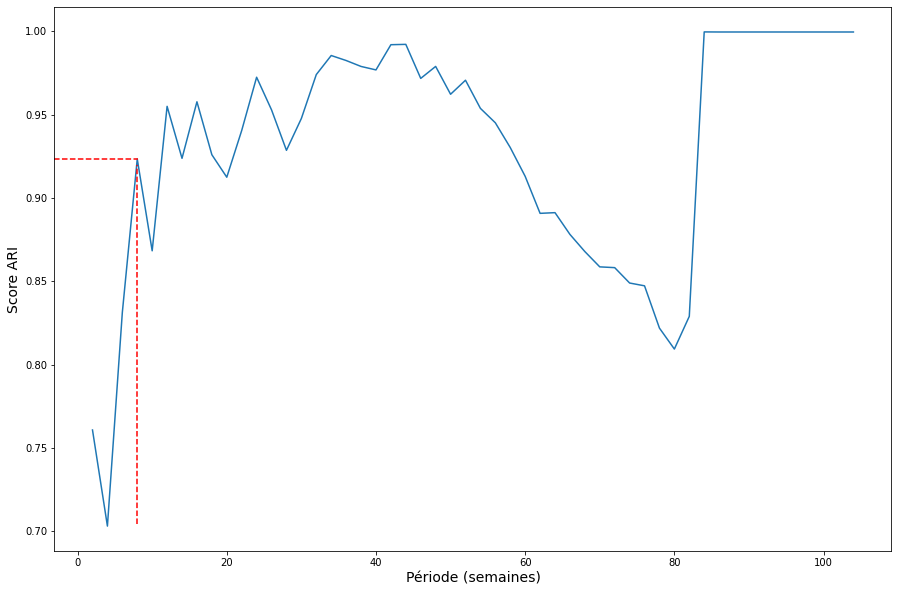

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(x=period, y=ari_score)
plt.axvline(x=8, ymin=0.05, ymax = 0.71, color='r', ls='--')
plt.axhline(y = 0.9234249251372029,xmax = 0.1 , color = 'r',  ls='--')
plt.xlabel('Période (semaines)', fontsize = 14)
plt.ylabel('Score ARI', fontsize = 14)
plt.show()

Au vu des scores ARI obtenus sur les itérations par période de 2 semaines, on pourrait prévoir une maintenance à partir du moment où le score obtenu devient instable c'est à dire ici toutes les 8 semaines dans un premier temps, puis  re-tester cette stabilité au fil du temps afin de l'affiner. Il sera donc également nécessaire de redéfinir les segments clients à chaque maintenance.

In [ ]:
ari_score_cust, period_cust = [], []

model = KMeans(4, random_state = 0)
data = dataset(customers_size = True, nb = 93_000)

model.fit(data)
labels_data = model.labels_

for p in range(30, 93000, 500):

  data_period = dataset(customers_size = True, nb = p) 
  model.fit(data_period)

  predict = model.predict(data)
  period_cust.append(p)

  ari_score_cust.append(adjusted_rand_score(labels_data, predict))
  print(p)
  print(adjusted_rand_score(labels_data, predict))

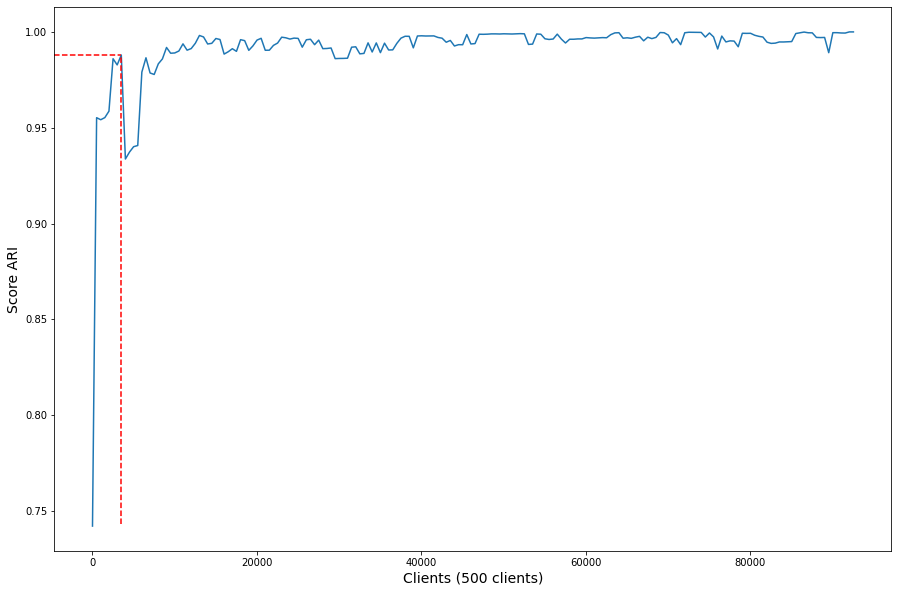

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(x=period_cust, y=ari_score_cust)
plt.axvline(x=3530, ymin=0.05, ymax = 0.91, color='r', ls='--')
plt.axhline(y = 0.9879592676064346,xmax = 0.08 , color = 'r',  ls='--')
plt.xlabel('Clients (500 clients)', fontsize = 14 )
plt.ylabel('Score ARI', fontsize = 14)
plt.show()

Ici au vu des scores obtenus par itération sur le nombres de clients par tranches de 500 clients on pourrait prévoir une maintenance à partir du moment où le score obtenu devient instable c'est à dire ici tous les 3530 clients dans un premier temps, puis re-tester cette stabilité au fil du temps afin de l'affiner. Il sera donc également nécessaire ici de redéfinir les segments clients à chaque maintenance.